In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import requests
import json
from pandas import json_normalize
import plotly.graph_objects as go

# Handball ELO Project 2012 Data

## Functions creating ELO

In [2]:
# Initial Variables that affect ELO
initial_rating = 1500
K = 16 # factor at which scores are updated
home_advantage = 32 #should be in number of elo points

def sigmoid_strength_of_victory(goal_dif, equation=1, elo_diff=0):
    """
    Calculate the strength of victory for a winning team based on the goal difference and optional parameters.

    Parameters:
    goal_dif (numeric): The goal difference for the match for the winning team.
    equation (int, optional): The equation used to calculate the strength of victory. Defaults to 1.
    elo_diff (numeric, optional): The Elo rating difference between the two teams. Defaults to 0.

    Returns:
    float: The strength of victory, representing the reward for the winning team.

    The function calculates the strength of victory based on different equations depending on the chosen equation
    parameter.

    If equation = 1:
        The function uses a sigmoid function to determine the strength of victory. A team that wins by a larger goal
        difference should be rewarded more, but extremely large wins are not overvalued.

    If equation = 2:
        The function uses the 538 Model to calculate the strength of victory. This model takes into account
        both the goal difference and the Elo rating difference between the teams. This has not been implemented yet.

    Example:
    goal_dif = 5
    equation = 1
    sigmoid_strength_of_victory(goal_dif, equation)  # Returns 1.2294464977081369

    goal_dif = 4
    equation = 2
    elo_diff = 100
    sigmoid_strength_of_victory(goal_dif, equation, elo_diff)  # Returns 0.8648752922373572
    """

    if equation == 1: 
        sov = (6.2 / (2 + math.exp(-(1 / 5) * (goal_dif - 8))))
    elif equation == 2:
        sov = np.log(goal_dif + 1) * (2.2 / (elo_diff + 2.2))
    return sov

def calculate_expected(team1, team2):
    """
    Calculate the expected outcome of a match between two teams, taking into account the home team advantage.

    Parameters:
    team1 (numeric): Elo rating for the first team.
    team2 (numeric): Elo rating for the second team.

    Returns:
    float: The expected probability of the first team winning, considering the home team advantage.

    The function uses the Elo rating system formula to calculate the expected outcome of a match. The Elo rating
    represents the skill level of a team or player. The higher the Elo rating, the stronger the team.

    The home team advantage is factored into the calculation by adjusting the Elo rating of the home team. The home
    team advantage is represented by a numeric value.

    Example:
    team1 = 1600
    team2 = 1500
    home_advantage = 100
    calculate_expected(team1, team2)  # Returns 0.7597468482494313

    team1 = 1500
    team2 = 1600
    home_advantage = 100
    calculate_expected(team1, team2) # Returns 0.5
    """
    team1_expected = 1 / (1 + math.pow(10, (team2 - (team1 + home_advantage)) / 400))
    return team1_expected


def update_ratings(home_team_rating, away_team_rating, goal_difference):
    """
    Update team ratings based on match outcome and goal difference.

    Parameters:
    home_team_rating (numeric): The rating of the home team.
    away_team_rating (numeric): The rating of the away team.
    goal_difference (numeric): The difference in goals between the home and away team.

    Returns:
    float: The updated rating of the home team.

    The function updates the ratings of the home team based on the match outcome and goal difference. The outcome is
    determined by the goal difference, where a goal difference of 0 results in a draw (outcome = 0.5), a positive goal
    difference indicates a win for the home team (outcome = 1), and a negative goal difference indicates a loss for the
    home team (outcome = 0).

    The expected outcome is calculated using the 'calculate_expected' function, which estimates the probability of the
    home team winning based on their rating and the away team's rating.

    The strength of victory is calculated using the 'sigmoid_strength_of_victory' function, which determines the
    reward for the home team based on the goal difference.

    The updated rating is computed using the formula:
    updated_rating = home_team_rating + (K * strength_of_victory * (outcome - expected))

    Example:
    home_team_rating = 1500
    away_team_rating = 1600
    goal_difference = 2
    update_ratings(home_team_rating, away_team_rating, goal_difference)  # Returns the updated rating of the home team
    """

    outcome = 0.5 if goal_difference == 0 else 1 if goal_difference > 0 else 0

    expected = calculate_expected(home_team_rating, away_team_rating)

    strength_of_victory = sigmoid_strength_of_victory(goal_difference)

    updated_rating = home_team_rating + (K * strength_of_victory * (outcome - expected))
    return updated_rating

def update_away_ratings(home_team_rating, away_team_rating, goal_difference):
    """
    Update the away team's rating based on the match outcome and goal difference.

    Parameters:
    home_team_rating (numeric): The rating of the home team.
    away_team_rating (numeric): The rating of the away team.
    goal_difference (numeric): The difference in goals between the home and away team.

    Returns:
    float: The updated rating of the away team.

    The function updates the rating of the away team based on the match outcome and goal difference. The outcome is
    determined by the goal difference, where a goal difference of 0 results in a draw (outcome = 0.5), an absolute
    goal difference greater than 0 indicates a loss for the away team (outcome = 0), and an absolute goal difference
    equal to 0 indicates a win for the away team (outcome = 1).

    The expected outcome is calculated using the Elo rating formula, which estimates the probability of the away team
    winning based on the ratings of the home and away teams. The formula used is:
    expected = 1 / (1 + math.pow(10, ((home_team_rating + home_advantage) - away_team_rating) / 400))

    The strength of victory is calculated using the 'sigmoid_strength_of_victory' function, which determines the
    reward for the away team based on the absolute value of the goal difference.

    The updated rating is computed using the formula:
    updated_rating = away_team_rating + (K * strength_of_victory * (outcome - expected))

    Example:
    home_team_rating = 1600
    away_team_rating = 1500
    goal_difference = -1
    update_away_ratings(home_team_rating, away_team_rating, goal_difference)  # Returns the updated rating of the away team
    """

    outcome = 0.5 if goal_difference == 0 else 1 if abs(goal_difference) > 0 else 0

    expected = 1 / (1 + math.pow(10, ((home_team_rating + home_advantage) - away_team_rating) / 400))

    strength_of_victory = sigmoid_strength_of_victory(abs(goal_difference))

    updated_rating = away_team_rating + (K * strength_of_victory * (outcome - expected))
    return updated_rating

## Getting Match Data from the API

In [3]:
# ## Get Match Data
# def get_match_data(year):
#     url = "https://v1.handball.api-sports.io/games?league=39&season={year}"

#     payload={}
#     headers = {
#     'x-rapidapi-key': 'API_KEY',
#     'x-rapidapi-host': 'v1.handball.api-sports.io'
#     }

#     response = requests.request("GET", url, headers=headers, data=payload)
#     response_text = response.text
#     response_json = json.loads(response_text)

#     file_name = file_name
#     return response_json

# def normalize_match_data(response_json,file_name):
#     with open(file_name, "w") as file:
#         json.dump(response_json, file)


#     with open(file_name) as f:
#         data = json.load(f)

#     df = pd.json_normalize(data)
#     return df

In [18]:
# Open and load the JSON file
with open('data/2012.json') as f:
    data = json.load(f)

# Convert the JSON data to a DataFrame
df = pd.json_normalize(data)
df

,id,date,time,timestamp,timezone,week,status.long,status.short,country.id,country.name,...,teams.home.logo,teams.away.id,teams.away.name,teams.away.logo,scores.home,scores.away,periods.first.home,periods.first.away,periods.second.home,periods.second.away
0,109064,2012-08-24T17:45:00+00:00,17:45,1345830300,UTC,1,Finished,FT,13,Germany,...,https://media-3.api-sports.io/handball/teams/3...,324,MT Melsungen,https://media-2.api-sports.io/handball/teams/3...,23,23,12.0,10.0,11.0,13.0
1,109065,2012-08-25T14:00:00+00:00,14:00,1345903200,UTC,1,Finished,FT,13,Germany,...,https://media-3.api-sports.io/handball/teams/3...,321,Kiel,https://media-1.api-sports.io/handball/teams/3...,25,34,10.0,16.0,15.0,18.0
2,109066,2012-08-25T17:00:00+00:00,17:00,1345914000,UTC,1,Finished,FT,13,Germany,...,https://media-3.api-sports.io/handball/teams/3...,326,N-Lubbecke,https://media-2.api-sports.io/handball/teams/3...,29,32,15.0,18.0,14.0,14.0
3,109067,2012-08-25T17:00:00+00:00,17:00,1345914000,UTC,1,Finished,FT,13,Germany,...,https://media-1.api-sports.io/handball/teams/3...,319,Hamburg,https://media-1.api-sports.io/handball/teams/3...,33,26,15.0,14.0,18.0,12.0
4,109068,2012-08-25T17:00:00+00:00,17:00,1345914000,UTC,1,Finished,FT,13,Germany,...,https://media-1.api-sports.io/handball/teams/3...,317,HBW Balingen-Weilstetten,https://media-1.api-sports.io/handball/teams/3...,25,20,12.0,9.0,13.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,109365,2013-06-08T14:30:00+00:00,14:30,1370701800,UTC,34,Finished,FT,13,Germany,...,https://media-3.api-sports.io/handball/teams/3...,325,Minden,https://media-1.api-sports.io/handball/teams/3...,32,28,17.0,9.0,15.0,19.0
302,109366,2013-06-08T14:30:00+00:00,14:30,1370701800,UTC,34,Finished,FT,13,Germany,...,https://media-2.api-sports.io/handball/teams/3...,369,Essen,https://media-1.api-sports.io/handball/teams/3...,24,23,15.0,10.0,9.0,13.0
303,109367,2013-06-08T14:30:00+00:00,14:30,1370701800,UTC,34,Finished,FT,13,Germany,...,https://media-1.api-sports.io/handball/teams/3...,319,Hamburg,https://media-1.api-sports.io/handball/teams/3...,30,30,17.0,14.0,13.0,16.0
304,109368,2013-06-08T14:30:00+00:00,14:30,1370701800,UTC,34,Finished,FT,13,Germany,...,https://media-3.api-sports.io/handball/teams/3...,317,HBW Balingen-Weilstetten,https://media-3.api-sports.io/handball/teams/3...,35,22,14.0,12.0,21.0,10.0


In [19]:
def clean_df(df):
    df = df[["date", "week", "teams.home.name", "scores.home", "teams.away.name", "scores.away", "league.season"]]
    df['difference'] = df['scores.home'] - df['scores.away']
    df['week'] = df['week'].astype(int)
    return df

In [20]:
df = clean_df(df)
df

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3851751148.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3851751148.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,week,teams.home.name,scores.home,teams.away.name,scores.away,league.season,difference
0,2012-08-24T17:45:00+00:00,1,Grosswallstadt,23,MT Melsungen,23,2012,0
1,2012-08-25T14:00:00+00:00,1,Gummersbach,25,Kiel,34,2012,-9
2,2012-08-25T17:00:00+00:00,1,Lemgo,29,N-Lubbecke,32,2012,-3
3,2012-08-25T17:00:00+00:00,1,HSG Wetzlar,33,Hamburg,26,2012,7
4,2012-08-25T17:00:00+00:00,1,Hannover-Burgdorf,25,HBW Balingen-Weilstetten,20,2012,5
...,...,...,...,...,...,...,...,...
301,2013-06-08T14:30:00+00:00,34,HSG Wetzlar,32,Minden,28,2012,4
302,2013-06-08T14:30:00+00:00,34,Lemgo,24,Essen,23,2012,1
303,2013-06-08T14:30:00+00:00,34,MT Melsungen,30,Hamburg,30,2012,0
304,2013-06-08T14:30:00+00:00,34,Rhein-Neckar,35,HBW Balingen-Weilstetten,22,2012,13


In [21]:
# Create a dictionary to store the latest ELO rating for each team
elo_dict = {}
end_of_season_elo_dict = {}

# Initialize a variable to keep track of the current season
current_season = df['league.season'].iloc[0]

# The regression factor and the initial Elo rating for new teams
regression_factor = 0.67
initial_elo = 1500

# Get the set of all teams
teams = set(df['teams.home.name']).union(set(df['teams.away.name']))

# Create empty lists to store the new ELO ratings and the ratings before the match
home_elo_ratings = []
away_elo_ratings = []
home_elo_before_match = []
away_elo_before_match = []

# Go through each row in the dataframe
for idx, row in df.iterrows():

    home_team = row['teams.home.name']
    away_team = row['teams.away.name']
    score_diff = row['difference']
    
    # Check if the home team is in the Elo ratings dictionary
    if home_team not in elo_dict:
        elo_dict[home_team] = 1500

    # Check if the away team is in the Elo ratings dictionary
    if away_team not in elo_dict:
        elo_dict[away_team] = 1500

    # Check if the season has changed
    if row['league.season'] != current_season:
        # If the season has changed, regress the Elo ratings towards the mean
        end_of_season_elo_dict[current_season] = sum(elo_dict.values())
        for team in elo_dict:
            elo_dict[team] = regression_factor * (elo_dict[team] - initial_elo) + initial_elo

        # Update the current season
        current_season = row['league.season']

    # Store the ratings before the match
    home_elo_before_match.append(elo_dict[home_team])
    away_elo_before_match.append(elo_dict[away_team])
    
    if score_diff >= 0: 
        new_home_elo = update_ratings(elo_dict[home_team], elo_dict[away_team], score_diff)
        new_away_elo = elo_dict[away_team] - (new_home_elo - elo_dict[home_team])
    
    else: 
        new_away_elo = update_away_ratings(elo_dict[home_team], elo_dict[away_team], score_diff)
        new_home_elo = elo_dict[home_team] - (new_away_elo - elo_dict[away_team])

    home_elo_ratings.append(new_home_elo)
    away_elo_ratings.append(new_away_elo)

        # Update the ELO ratings in our dictionary
    elo_dict[home_team] = new_home_elo
    elo_dict[away_team] = new_away_elo

# Add the new ELO ratings to the dataframe
df['home_elo_rating'] = home_elo_ratings
df['away_elo_rating'] = away_elo_ratings

# Add the ELO ratings before the match to the dataframe
df['home_elo_before_match'] = home_elo_before_match
df['away_elo_before_match'] = away_elo_before_match

df

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3337369397.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3337369397.py:67: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3337369397.py:70: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,date,week,teams.home.name,scores.home,teams.away.name,scores.away,league.season,difference,home_elo_rating,away_elo_rating,home_elo_before_match,away_elo_before_match
0,2012-08-24T17:45:00+00:00,1,Grosswallstadt,23,MT Melsungen,23,2012,0,1499.344825,1500.655175,1500.000000,1500.000000
1,2012-08-25T14:00:00+00:00,1,Gummersbach,25,Kiel,34,2012,-9,1480.787291,1519.212709,1500.000000,1500.000000
2,2012-08-25T17:00:00+00:00,1,Lemgo,29,N-Lubbecke,32,2012,-3,1488.522209,1511.477791,1500.000000,1500.000000
3,2012-08-25T17:00:00+00:00,1,HSG Wetzlar,33,Hamburg,26,2012,7,1513.982898,1486.017102,1500.000000,1500.000000
4,2012-08-25T17:00:00+00:00,1,Hannover-Burgdorf,25,HBW Balingen-Weilstetten,20,2012,5,1511.785229,1488.214771,1500.000000,1500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
301,2013-06-08T14:30:00+00:00,34,HSG Wetzlar,32,Minden,28,2012,4,1520.185448,1351.494484,1514.265626,1357.414306
302,2013-06-08T14:30:00+00:00,34,Lemgo,24,Essen,23,2012,1,1512.732673,1287.698735,1509.603740,1290.827669
303,2013-06-08T14:30:00+00:00,34,MT Melsungen,30,Hamburg,30,2012,0,1486.261064,1629.085225,1483.975188,1631.371100
304,2013-06-08T14:30:00+00:00,34,Rhein-Neckar,35,HBW Balingen-Weilstetten,22,2012,13,1639.488368,1423.064518,1630.719515,1431.833371


### Formalization of Percentages for Betting

In [31]:
# Calculate the expected outcome (win probability) for the home team and the away team
df['home_win_probability'] = 1 / (1 + 10**(((df['away_elo_before_match'] - (df['home_elo_before_match'] + home_advantage)) / 400))) * 100
df['away_win_probability'] = 100 - df['home_win_probability']

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/2739960020.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/2739960020.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
# Rewrite the format of the date
df['date'] = pd.to_datetime(df['date']).dt.date

# Split the dataframe into home and away matches
df_home = df[['date', 'league.season', 'teams.home.name', 'home_elo_rating']]
df_away = df[['date', 'league.season', 'teams.away.name', 'away_elo_rating']]

# Rename the columns to prepare for the pivot
df_home.columns = ['Date','Season','Team', 'Rating']
df_away.columns = ['Date','Season','Team', 'Rating']

# Append the dataframes
df_all = df_home.append(df_away)

# Pivot the dataframe

df_pivot = df_all.pivot_table(index = "Team", columns = 'Date', values = 'Rating')

# Sort the columns
df_pivot = df_pivot.sort_index(axis=1)

# Fill ELO values for the rest of the dates
df_pivot = df_pivot.fillna(method = 'ffill', axis = 1)

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/860415150.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Matplotlib Graph

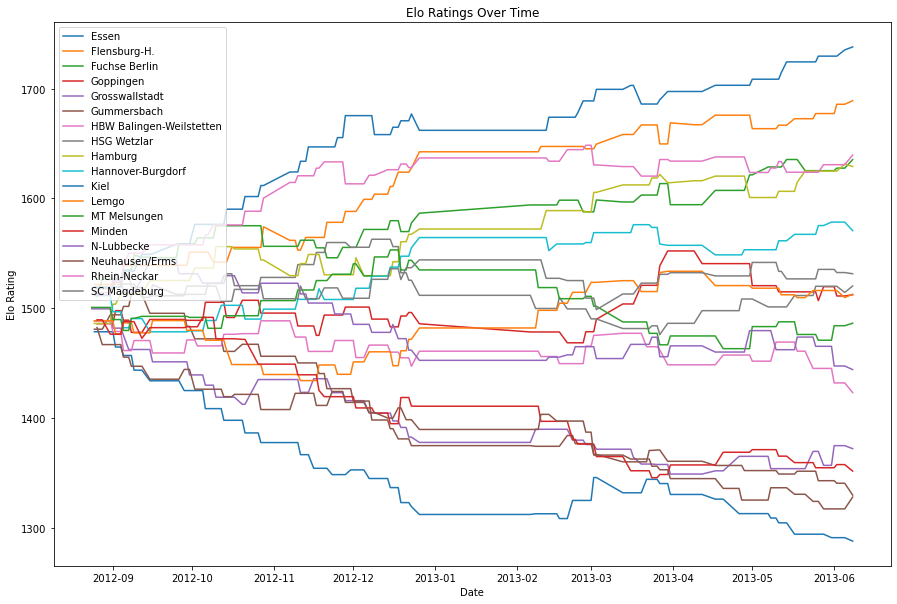

In [43]:
# Plot each team's Elo rating over time
plt.figure(figsize=(15,10))

for team in df_pivot.index:
    plt.plot(df_pivot.columns, df_pivot.loc[team], label=team)

plt.xlabel('Date')
plt.ylabel('Elo Rating')
plt.title('Elo Ratings Over Time')
plt.legend(loc='upper left')
plt.show()

## Plotly Graph

In [44]:
fig = go.Figure()

for team in df_pivot.index:
    fig.add_trace(go.Scatter(x=df_pivot.columns, 
                             y=df_pivot.loc[team],
                             mode='lines',
                             name=team))

fig.update_layout(title='Elo Ratings Over Time',
                  xaxis_title='Date',
                  yaxis_title='Elo Rating')

fig.show()

### Checking accuracy of Model

In [46]:
# Create a column to indicate whether the home team won, lost or tied
df['home_team_won'] = np.where(df['scores.home'] > df['scores.away'], 'Won',
                               np.where(df['scores.home'] < df['scores.away'], 'Lost', 'Tied'))

# Create a column to check if the home_win_probability was correct
# If home_win_probability > 50, the model predicts home team to win
# If home_win_probability < 50, the model predicts home team to lose
# If it's a tie, the prediction is considered correct only if home_win_probability is exactly 50%
conditions = (
    ((df['home_win_probability'] > 50) & (df['home_team_won'] == 'Won')) |
    ((df['home_win_probability'] < 50) & (df['home_team_won'] == 'Lost')) |
    ((df['home_win_probability'] == 50) & (df['home_team_won'] == 'Tied'))
)
df['prediction_correct'] = np.where(conditions, 'Yes', 'No')

# Create a column to indicate the bin for each game's home win probability
df['probability_bin'] = pd.cut(df['home_win_probability'], bins=np.arange(0, 110, 10))

# Group by the probability bin and calculate the percentage of correct predictions in each bin
accuracy_by_bin = df.groupby('probability_bin')['prediction_correct'].apply(lambda x: (x == 'Yes').mean() * 100)

# Group by the probability bin, calculate the percentage of correct predictions 
# in each bin and also count the number of predictions
grouped = df.groupby('probability_bin').agg({'prediction_correct': lambda x: (x == 'Yes').mean() * 100,
                                             'home_win_probability': 'count'})

# Rename the columns for clarity
grouped.columns = ['Accuracy (%)', 'Sample Size']

print(grouped)


                 Accuracy (%)  Sample Size
probability_bin                           
(0, 10]                   NaN            0
(10, 20]           100.000000            8
(20, 30]            70.000000           30
(30, 40]            62.790698           43
(40, 50]            43.209877           81
(50, 60]            68.656716           67
(60, 70]            80.000000           40
(70, 80]            90.000000           20
(80, 90]           100.000000           17
(90, 100]                 NaN            0


/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3816471173.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3816471173.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/7f/mvyr_rjd1q3cmtdd3m2026rh0000gn/T/ipykernel_3004/3816471173.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do